# Smart City Mobility Demand Predictor

This service leverages Machine Learning to predict urban mobility demand and provide personalized notifications to citizens. Using a Random Forest model, it analyzes historical bus delay data from [Toronto TTC](https://www.kaggle.com/datasets/reihanenamdari/toronto-bus-delay-2022), incorporating features such as route, time, day, location, incident reports, and vehicle details. The objective is to enhance transportation scheduling and resource allocation. Users can receive tailored notifications about expected delays, optimal travel times, and route recommendations.

**Author: Danne M. Pereira.**

**Project: [UFCity](https://makleyston-ufc.github.io/ufcity/)**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('../datasets/toronto-bus-delay-2022/ttc-bus-delay-data-2022.csv')

In [3]:
df.columns

Index(['Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay',
       'Min Gap', 'Direction', 'Vehicle'],
      dtype='object')

In [4]:
df.dtypes

Date         object
Route        object
Time         object
Day          object
Location     object
Incident     object
Min Delay     int64
Min Gap       int64
Direction    object
Vehicle       int64
dtype: object

In [5]:
df.describe()

,Min Delay,Min Gap,Vehicle
count,27351.000000,27351.000000,27351.000000
mean,20.298417,32.876714,5410.169427
std,49.636736,51.293913,4616.285325
min,0.000000,0.000000,0.000000
25%,9.000000,17.000000,1394.000000
50%,11.000000,22.000000,7940.000000
75%,20.000000,36.000000,8523.000000
max,999.000000,999.000000,93561.000000


In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Date            0
Route         164
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Direction    5577
Vehicle         0
dtype: int64


In [7]:
# Handling missing data
df['Route'] = df['Route'].fillna(df['Route'].mode()[0])
df['Direction'] = df['Direction'].fillna(df['Direction'].mode()[0])

/home/makleyston/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/makleyston/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/makleyston/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.w

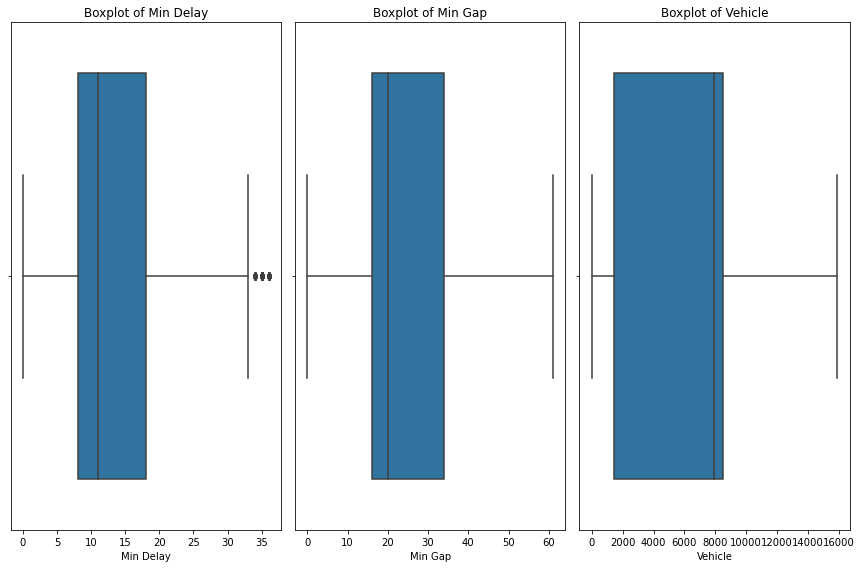

In [8]:
# Identify and remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to relevant numeric columns
numeric_columns = ['Min Delay', 'Min Gap', 'Vehicle']  # Inclua outras colunas se necessário
for column in numeric_columns:
    df = remove_outliers_iqr(df, column)

# Check for remaining outliers
import seaborn as sns
plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)
    sns.boxplot(df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()


In [9]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert 'Time' to hour (considering it is in 'HH:MM' format)
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour

# Extract additional features from 'Date'
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

In [10]:
# Convert categorical data to numerical
label_encoders = {}
for column in ['Route', 'Day', 'Location', 'Incident', 'Direction']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

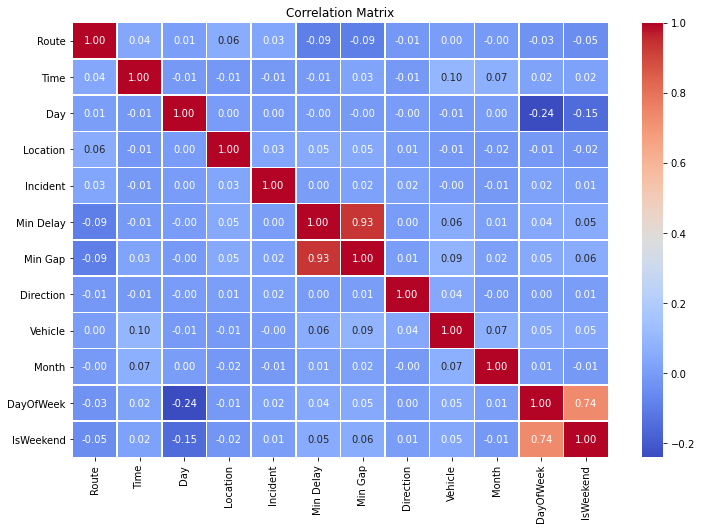

In [11]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Modeling RandomForest

In [12]:
# Define features and target variable
X = df[['Route', 'Time', 'Day', 'Location', 'Incident', 'Min Gap', 'Direction', 'Vehicle', 'Month', 'DayOfWeek', 'IsWeekend']]
y = df['Min Delay']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 0.8861572800864961
Mean Squared Error: 5.916579228805166


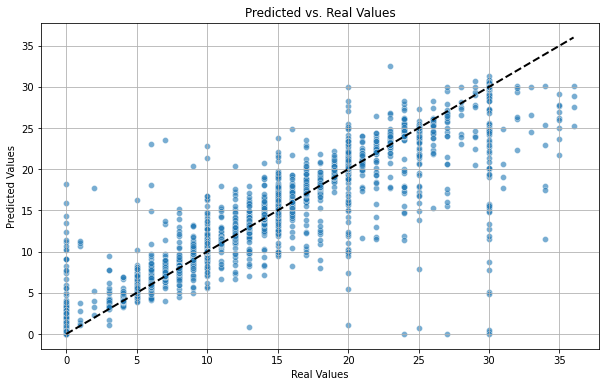

In [14]:
import matplotlib.pyplot as plt

# Plotando as previsões versus os valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Linha de identidade
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Real Values')
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import r2_score

# Calcular o R²
r2 = r2_score(y_test, y_pred)
print(f'R² (Coefficient of Determination): {r2}')

# Converter R² em porcentagem
r2_percentage = r2 * 100
print(f'R² as a percentage: {r2_percentage:.2f}%')

R² (Coefficient of Determination): 0.892847963921944
R² as a percentage: 89.28%


In [16]:
import joblib
joblib.dump(rf_model, 'toronto-bus-demand-forecast-model.joblib')

['toronto-bus-demand-forecast-model.joblib']

In [17]:
print(joblib.__version__)

1.2.0


In [18]:
import sklearn
print(sklearn.__version__)

1.2.2


In [19]:
df.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Month,DayOfWeek,IsWeekend
0,2022-01-01,77,2,2,5338,5,0,0,8,8531,1,5,1
2,2022-01-01,77,2,2,5402,10,17,20,10,0,1,5,1
3,2022-01-01,77,2,2,5402,10,4,11,10,0,1,5,1
4,2022-01-01,77,2,2,5402,10,4,8,10,0,1,5,1
5,2022-01-01,97,2,2,2533,10,30,60,8,0,1,5,1


In [20]:
df.dtypes

Date         datetime64[ns]
Route                 int64
Time                  int64
Day                   int64
Location              int64
Incident              int64
Min Delay             int64
Min Gap               int64
Direction             int64
Vehicle               int64
Month                 int64
DayOfWeek             int64
IsWeekend             int64
dtype: object

In [30]:
manual_input = {
    'Route': 1,
    'Time': 2,
    'Day': 3,
    'Location': 2533,
    'Incident': 0,
    'Min Gap': 5,
    'Direction': 8,
    'Vehicle': 1234,
    'Month':1,
    'DayOfWeek':15,
    'IsWeekend':2
}

manual_df = pd.DataFrame([manual_input])

prediction = rf_model.predict(manual_df)
print(f'Predicted Demand: {prediction[0]}')

Predicted Demand: 10.34
